In [425]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [426]:
start = datetime(2001,1,1)
end  = datetime(2020,1,1)
# start = datetime(2020,1,1)
# end = datetime.now()
current_date = datetime(2023,1,1)

In [427]:
market = Market()

In [428]:
pricer_classes = [] 
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)

In [429]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [430]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [431]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                ledger= ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:25<00:00,  3.68s/it]


In [432]:
trade

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,iteration
0,2001,2001-01-29,JKHY,0.394300,1.0,1.009275,0,2
1,2001,2001-01-30,ABMD,0.340044,1.0,0.978317,0,2
2,2001,2001-01-31,JKHY,0.285714,1.0,1.008109,0,2
3,2001,2001-02-01,ADBE,0.376287,1.0,0.958627,0,2
4,2001,2001-02-02,NTAP,0.579897,1.0,0.926417,0,2
...,...,...,...,...,...,...,...,...
103855,2023,2023-07-21,ALB,0.091121,1.0,0.975971,19,2
103856,2023,2023-07-24,GPC,0.085983,1.0,1.001777,19,2
103857,2023,2023-07-25,IPGP,0.089952,1.0,1.011327,19,2
103858,2023,2023-07-26,TSLA,0.105775,1.0,0.967316,19,2


In [433]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
6,True,False,False,False,flat,1,tyield1,1,0,dsr_n_n_b_r,9734.467320,-0.113711,0.973782,-85598.234855
8,True,False,False,False,none,1,tyield1,1,2,dsr_n_n_b_r,9214.249377,-0.113680,0.973825,-81045.173214
3,True,False,False,False,flat,1,tyield1,1,0,wsw_n_n_b_r,2380.942255,-0.007094,0.996338,-335474.669122
5,True,False,False,False,none,1,tyield1,1,2,wsw_n_n_b_r,2376.794621,-0.006851,0.996484,-346788.195955
11,True,False,False,False,none,1,tyield1,1,2,dsw_n_n_b_r,783.197010,-0.038382,0.991220,-20379.061276
9,True,False,False,False,flat,1,tyield1,1,0,dsw_n_n_b_r,706.823730,-0.046031,0.989488,-15333.699080
10,True,False,False,False,rrr,1,tyield1,1,1,dsw_n_n_b_r,600.554234,-0.037327,0.991467,-16062.367586
7,True,False,False,False,rrr,1,tyield1,1,1,dsr_n_n_b_r,355.588660,-0.005629,0.998786,-62995.191126
18,True,False,False,False,flat,1,tyield1,1,0,dsb_n_n_b_r,286.301852,-0.041347,0.990535,-6900.186657
20,True,False,False,False,none,1,tyield1,1,2,dsb_n_n_b_r,281.690047,-0.041706,0.990452,-6730.261997


In [434]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
3,dsr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,9734.467320,-0.113711,0.973782,-85598.234855
6,wsw_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,2380.942255,-0.007094,0.996338,-335474.669122
4,dsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,783.197010,-0.038382,0.991220,-20379.061276
0,dsb_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,286.301852,-0.041347,0.990535,-6900.186657
5,wsr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,191.345808,0.029342,1.018263,6487.203857
1,dsdr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,15.718267,0.006077,1.001490,2421.749698
2,dsmr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,0.993814,0.482446,0.917712,-0.013000


In [435]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [436]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [437]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [438]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-29,JKHY,0.177996,1.0,1.009275,0,Information Technology,Jack Henry & Associates
1,2001,2001-01-30,BALL,0.102314,1.0,1.000751,0,Materials,Ball Corporation
2,2001,2001-01-31,JNPR,0.109831,1.0,1.022663,0,Information Technology,Juniper Networks
3,2001,2001-02-01,ADBE,0.210815,1.0,0.958627,0,Information Technology,Adobe Inc.
4,2001,2001-02-02,NTAP,0.259171,1.0,0.926417,0,Information Technology,NetApp
...,...,...,...,...,...,...,...,...,...
64041,2019,2019-11-13,CHD,0.061514,1.0,0.998208,19,Consumer Staples,Church & Dwight
64042,2019,2019-11-14,TAP,0.054216,1.0,1.023782,19,Consumer Staples,Molson Coors Beverage Company
64043,2019,2019-11-15,AAP,0.050721,1.0,1.006209,19,Consumer Discretionary,Advance Auto Parts
64044,2019,2019-11-22,ROL,0.050785,1.0,0.995209,19,Industrials,"Rollins, Inc."


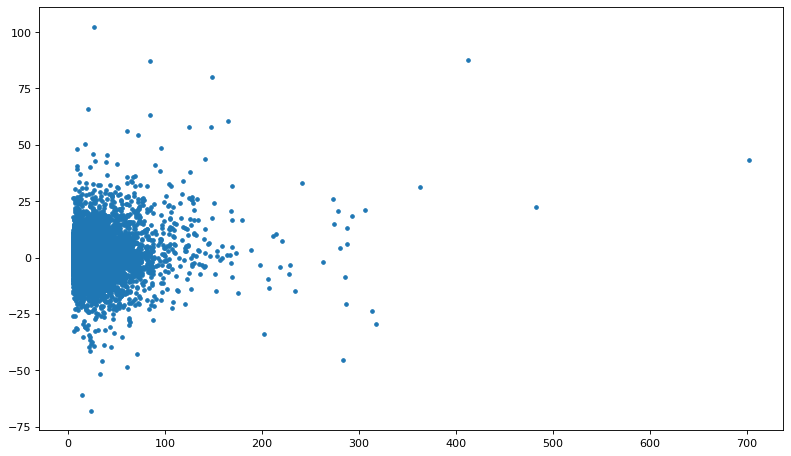

In [439]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [440]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-29,JKHY,0.177996,1.0,1.009275,0,Information Technology,Jack Henry & Associates
4358,2001,2001-01-29,TXN,0.136640,1.0,1.017747,1,Information Technology,Texas Instruments
8668,2001,2001-01-29,ORLY,0.134188,1.0,1.000000,2,Consumer Discretionary,O'Reilly Auto Parts
12887,2001,2001-01-29,MCD,0.126259,1.0,0.997629,3,Consumer Discretionary,McDonald's
17000,2001,2001-01-29,BALL,0.121000,1.0,0.988366,4,Materials,Ball Corporation
20978,2001,2001-01-29,SJM,0.112765,1.0,1.035324,5,Consumer Staples,The J.M. Smucker Company
24789,2001,2001-01-29,ROL,0.112211,1.0,1.002950,6,Industrials,"Rollins, Inc."
28444,2001,2001-01-29,PHM,0.096891,1.0,0.983742,7,Consumer Discretionary,PulteGroup
31928,2001,2001-01-29,WRB,0.095707,1.0,1.006792,8,Financials,Berkley
35255,2001,2001-01-29,DD,0.095359,1.0,1.054891,9,Materials,DuPont


In [441]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
18724,2008,2008-12-04,HIG,0.261279,1.0,2.023578,4,Financials,Hartford (The)
354,2002,2002-07-26,WMB,4.123295,1.0,1.877358,0,Energy,Williams Companies
29958,2008,2008-10-10,MS,0.846386,1.0,1.869835,7,Financials,Morgan Stanley
1806,2008,2008-10-28,LVS,1.485776,1.0,1.800000,0,Consumer Discretionary,Las Vegas Sands
10514,2009,2009-03-13,AIG,0.207317,1.0,1.660000,2,Financials,American International Group
4710,2002,2002-07-24,CNP,0.846646,1.0,1.629630,1,Utilities,CenterPoint Energy
6198,2009,2009-02-05,FITB,1.650000,1.0,1.603659,1,Financials,Fifth Third Bank
14646,2008,2008-11-21,C,1.247784,1.0,1.578249,3,Financials,Citigroup
1809,2008,2008-10-31,HIG,1.469802,1.0,1.577519,0,Financials,Hartford (The)
48,2001,2001-04-06,EQIX,0.605825,1.0,1.559322,0,Real Estate,Equinix


In [442]:
ledger["actual_returns"].mean()

1.001650879031311

In [443]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5114292852012616

In [444]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [445]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2001-01-29,1.009275,1.017747,1.000000,0.997629,0.988366,1.035324,1.002950,0.983742,...,0.987383,1.028966,1.027348,1.005714,0.969803,0.953846,1.000418,1.000879,1.039106,0.977344
1,2001,2001-01-30,1.000751,0.978317,0.991020,0.996604,1.038235,1.022727,0.953008,1.010870,...,0.944414,1.001219,0.942171,1.010408,1.065041,0.979209,1.009658,0.970000,1.006143,1.007143
2,2001,2001-01-31,1.022663,1.023524,1.003969,1.028406,0.989097,1.028364,1.011111,0.996601,...,1.000410,1.026087,1.030184,1.012945,1.005429,1.025971,0.986251,0.992051,1.002147,1.000000
3,2001,2001-02-01,0.958627,0.983210,0.929825,1.036775,1.004081,0.989130,1.019039,0.976284,...,1.053046,0.976888,0.991083,0.923154,1.025855,0.978341,1.001553,0.893333,0.985587,1.000946
4,2001,2001-02-02,0.926417,1.018062,1.041781,1.040715,1.009550,1.006308,0.935454,1.004172,...,1.013312,1.002231,1.008667,1.074286,1.024326,0.988755,1.039837,1.018783,0.995600,0.942529
5,2001,2001-02-05,1.094875,1.036250,0.975191,0.969590,0.991935,0.961167,0.982158,1.021815,...,1.004727,0.977585,1.037379,1.032857,1.035976,1.034433,1.008112,1.003682,0.953608,1.033829
6,2001,2001-02-06,0.860740,0.948767,1.024027,0.986409,0.974634,0.923483,0.983716,0.934673,...,1.003086,1.033865,1.002172,0.868811,0.935620,0.950988,0.977341,1.014292,0.956835,0.974692
7,2001,2001-02-07,0.910950,0.925806,0.986014,0.891590,0.996330,0.976537,0.955556,0.958667,...,0.979776,1.081173,0.988132,0.993590,0.995853,0.978462,0.984152,0.949602,1.040850,1.062092
8,2001,2001-02-08,1.079852,0.984418,0.901354,0.951452,0.939667,0.972578,0.930459,0.974548,...,0.953570,0.981177,0.968456,0.960769,0.982220,1.002571,0.953582,0.983014,0.868411,0.992830
9,2001,2001-02-09,1.029737,1.070661,1.018066,0.952313,1.048599,1.083707,0.975976,1.002927,...,1.009912,0.992745,1.018102,1.020458,1.032137,1.024868,0.995313,1.029601,1.021368,0.976231


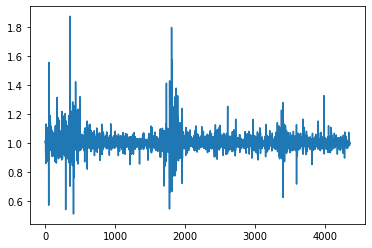

In [446]:
plt.plot(portfolio[0])

In [447]:
positions = 20

In [448]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [449]:
anas.naming

'date'

In [450]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,date,week,pv,daily_returns,adjclose,bench
4487,186169.181552,63.270415,3.445250,356.035023,41.794105,119.481226,4.857748,5.099283,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-13,50,9344.893051,1.001780,8576.5070,3.064564
4488,190481.372001,62.623376,3.447340,354.497075,41.278606,117.552395,4.857748,5.099283,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-16,51,9560.271212,0.999037,8668.8516,3.097561
4489,192683.832529,63.328128,3.504330,358.341946,40.835668,117.409864,4.919882,5.099283,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-17,51,9670.598402,1.002552,8668.8516,3.097561
4490,194036.772568,69.150949,3.534214,360.777805,42.522549,118.398390,4.989667,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-18,51,9738.794647,1.008431,8668.8516,3.097561
4491,193187.252079,69.668335,3.621266,354.827946,42.171650,121.182308,5.097635,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-19,51,9696.178401,1.002407,8668.8516,3.097561
4492,194996.416084,72.897483,3.570679,363.380037,41.626187,119.042789,5.096154,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-20,51,9787.088810,1.001748,8668.8516,3.097561
4493,197124.398564,73.567940,3.522548,361.200092,41.549597,118.772033,5.096154,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-23,52,9893.392686,0.999826,8855.4984,3.164253
4494,197501.521542,74.267803,3.496175,362.564996,41.190094,118.772033,5.096154,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-24,52,9912.332779,0.999953,8855.4984,3.164253
4495,196103.948155,73.654076,3.525522,358.875954,41.600539,118.772033,5.096154,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-26,52,9842.260961,0.999642,8855.4984,3.164253
4496,193952.128815,73.767461,3.556531,354.678078,41.600539,118.772033,5.096154,5.050386,45.829301,21.61083,...,3.396754,22.211159,1.003933,2019,2019-12-27,52,9734.467320,0.999383,8855.4984,3.164253


In [451]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [452]:
cash_analysis["cash"].sum()

2157.345613814013

In [453]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.004376,NaN,NaN,0.000000,0.000000
1,0.997029,1.000000,0.997029,0.000000,0.000000
2,1.009249,0.997029,1.006251,0.625059,0.625059
3,0.985751,1.000000,0.985751,0.000000,0.625059
4,1.004620,0.985751,0.990305,0.000000,0.625059
...,...,...,...,...,...
4492,1.001748,1.000000,1.001748,0.174837,2157.345614
4493,0.999826,1.000000,0.999826,0.000000,2157.345614
4494,0.999953,0.999826,0.999779,0.000000,2157.345614
4495,0.999642,0.999953,0.999595,0.000000,2157.345614


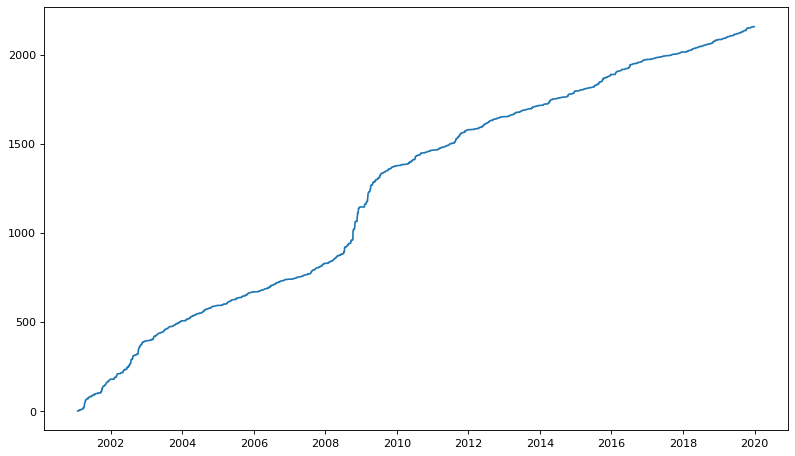

In [454]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

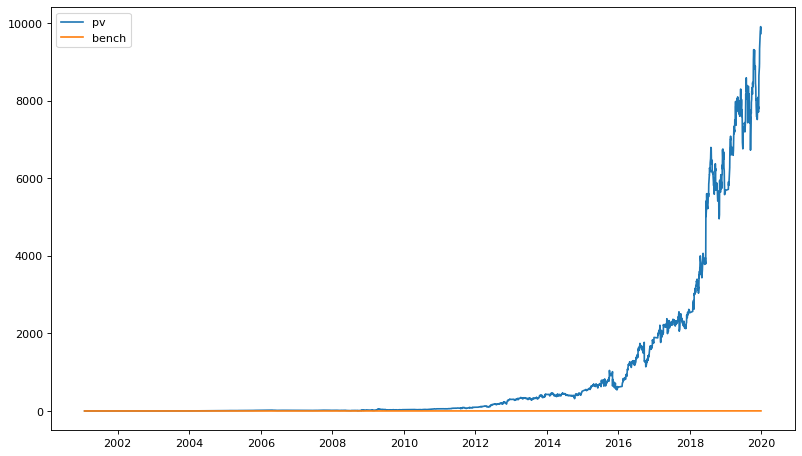

In [455]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [456]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,date,week,pv,daily_returns,adjclose,bench
0,1.009275,1.017747,1.000000,0.997629,0.988366,1.035324,1.002950,0.983742,1.006792,1.054891,...,1.000879,1.039106,0.977344,2001,2001-01-29,5,1.004376,1.004376,2798.606,1.000000
1,1.010033,0.995680,0.991020,0.994241,1.026157,1.058854,0.955819,0.994435,1.007084,1.068975,...,0.970852,1.045489,0.984325,2001,2001-01-30,5,1.001339,0.997029,2798.606,1.000000
2,1.032923,1.019102,0.994954,1.022483,1.014969,1.088887,0.966439,0.991054,0.998691,1.077643,...,0.963135,1.047734,0.984325,2001,2001-01-31,5,1.010588,1.009249,2798.606,1.000000
3,0.990188,1.001991,0.925132,1.060085,1.019111,1.077051,0.984839,0.967550,1.012452,1.050137,...,0.860401,1.032633,0.985256,2001,2001-02-01,5,0.996047,0.985751,2798.606,1.000000
4,0.917327,1.020089,0.963786,1.103247,1.028843,1.083846,0.921272,0.971587,1.010044,1.054327,...,0.876562,1.028089,0.928632,2001,2001-02-02,5,1.000571,1.004620,2798.606,1.000000
5,1.004359,1.057068,0.939875,1.069697,1.020546,1.041756,0.904835,0.992783,1.038265,1.097027,...,0.879790,0.980394,0.960047,2001,2001-02-05,6,1.011106,1.011181,2778.542,0.992831
6,0.864492,1.002911,0.962457,1.055159,0.994659,0.962045,0.890100,0.927928,1.015738,1.005027,...,0.892364,0.938075,0.935751,2001,2001-02-06,6,0.972009,0.962430,2778.542,0.992831
7,0.787509,0.928501,0.948996,0.940770,0.991008,0.939472,0.850540,0.889573,0.972350,1.020152,...,0.847391,0.976395,0.993853,2001,2001-02-07,6,0.954310,0.981373,2778.542,0.992831
8,0.850393,0.914034,0.855382,0.895097,0.931217,0.913710,0.791393,0.866932,0.927125,0.982768,...,0.832997,0.847913,0.986727,2001,2001-02-08,6,0.919866,0.964889,2778.542,0.992831
9,0.875681,0.978620,0.870835,0.852412,0.976473,0.990194,0.772380,0.869469,0.954206,1.064939,...,0.857654,0.866031,0.963273,2001,2001-02-09,6,0.939094,1.020777,2778.542,0.992831


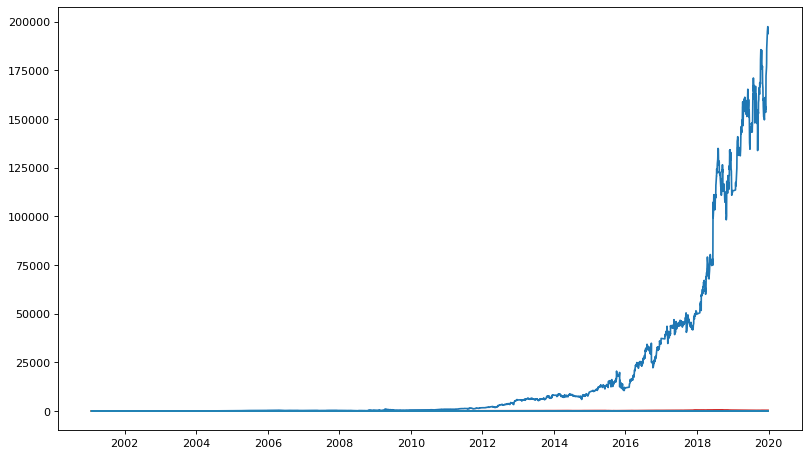

In [457]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [458]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Financials,2009.257983,0.150208,1.0,1.003270,9.177882
Utilities,2008.126349,0.138149,1.0,1.002496,8.900952
Energy,2011.957231,0.110338,1.0,1.001908,8.978883
Consumer Discretionary,2010.583663,0.115445,1.0,1.001865,8.092267
Health Care,2008.568010,0.123260,1.0,1.001671,7.572816
Consumer Staples,2010.169991,0.094116,1.0,1.001366,7.877710
Information Technology,2008.944738,0.126007,1.0,1.001327,7.880145
Industrials,2010.102316,0.121873,1.0,1.001293,8.471224
Real Estate,2008.010603,0.155115,1.0,1.001179,8.689198


In [459]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                      
2008 2008-12-04 HIG    Hartford (The)                     0.261279   
2002 2002-07-26 WMB    Williams Companies                 4.123295   
2008 2008-10-10 MS     Morgan Stanley                     0.846386   
     2008-10-28 LVS    Las Vegas Sands                    1.485776   
2009 2009-03-13 AIG    American International Group       0.207317   
2002 2002-07-24 CNP    CenterPoint Energy                 0.846646   
2009 2009-02-05 FITB   Fifth Third Bank                   1.650000   
2008 2008-11-21 C      Citigroup                          1.247784   
     2008-10-31 HIG    Hartford (The)                     1.469802   
2001 2001-04-06 EQIX   Equinix                            0.605825   
2008 2008-10-13 KEY    KeyCorp                            0.721060   
     2008-12-03 DXCM   Dexcom                             0.168500   
2009 2009-02-05 RF     Regions Financial Corporation      0.957400   
     2009-04-02 MGM    MGM Resorts                        0.093536   
2002 2002-07-25 JCI    Johnson Controls                   0.256100   
     2002-03-06 SBAC   SBA Communications                 0.396374   
2008 2008-11-24 LNC    Lincoln Financial                  1.411164   
     2008-09-18 AIG    American International Group       7.028461   
     2008-11-12 CBRE   CBRE Group                         0.272115   
2002 2002-11-14 ALGN   Align Technology                   0.387692   
2008 2008-07-15 UAL    United Airlines Holdings           0.504227   
2002 2002-07-26 AES    AES Corporation                    0.892373   
2014 2014-06-23 VRTX   Vertex Pharmaceuticals             0.092164   
2008 2008-07-16 HBAN   Huntington National Bank           0.223922   
2002 2002-10-30 AES    AES Corporation                    0.085484   
2008 2008-10-10 PRU    Prudential Financial               0.947460   
2009 2009-03-09 C      Citigroup                          1.251942   
2013 2013-02-13 STZ    Constellation Brands               0.126167   
2008 2008-10-30 LVS    Las Vegas Sands                    0.401852   
2002 2002-06-12 JCI    Johnson Controls                   0.686787   

                                                      dately_delta_sign  \
year date       ticker Security                                           
2008 2008-12-04 HIG    Hartford (The)                               1.0   
2002 2002-07-26 WMB    Williams Companies                           1.0   
2008 2008-10-10 MS     Morgan Stanley                               1.0   
     2008-10-28 LVS    Las Vegas Sands                              1.0   
2009 2009-03-13 AIG    American International Group                 1.0   
2002 2002-07-24 CNP    CenterPoint Energy                           1.0   
2009 2009-02-05 FITB   Fifth Third Bank                             1.0   
2008 2008-11-21 C      Citigroup                                    1.0   
     2008-10-31 HIG    Hartford (The)                               1.0   
2001 2001-04-06 EQIX   Equinix                                      1.0   
2008 2008-10-13 KEY    KeyCorp                                      1.0   
     2008-12-03 DXCM   Dexcom                                       1.0   
2009 2009-02-05 RF     Regions Financial Corporation                1.0   
     2009-04-02 MGM    MGM Resorts                                  1.0   
2002 2002-07-25 JCI    Johnson Controls                             1.0   
     2002-03-06 SBAC   SBA Communications                           1.0   
2008 2008-11-24 LNC    Lincoln Financial                            1.0   
     2008-09-18 AIG    American International Group                 1.0   
     2008-11-12 CBRE   CBRE Group                                   1.0   
2002 2002-11-14 ALGN   Align Technology                             1.0   
2008 2008-07-15 UAL    United Airlines Holdings                     1.0   
2002 2002-07-26 AES    AES Corporation                              1.0   
2014 2014-06-

In [460]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-29 00:00:00.000000000,1.000418,1.001920,1.035324,1.000000,0.997087,1.003155,1.002950,0.991277,1.027455,1.000000,1.000000
1,4004001,1720-02-06 09:03:13.464852480,1.000418,1.004029,1.041342,1.000000,0.941664,1.019707,1.041298,0.949771,1.029968,1.000000,1.000000
2,8012006001,1723-01-13 16:40:44.835356672,1.026399,1.017759,1.072774,0.991667,0.941547,1.014721,1.050105,0.964384,1.048748,1.000000,1.000000
3,16032024008001,1970-01-01 00:00:00.000000000,1.018268,1.015120,1.063208,1.044271,0.940313,1.040956,1.088723,0.923183,1.023876,1.000000,1.000000
4,32080080040010001,1970-01-01 00:00:00.000000000,1.036660,1.011922,1.063208,1.044057,0.945437,1.043279,1.099120,0.928230,1.043107,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4353,0,1970-01-01 00:00:00.000000000,3.815775,455.685080,4.892609,11.907072,8.072316,4.858361,14.581011,355.669120,4.375828,1.038491,3.491761
4354,0,1970-01-01 00:00:00.000000000,3.807097,454.846653,4.892609,11.907072,8.072316,4.911380,14.439003,355.669120,4.416074,1.038491,3.491761
4355,0,1970-01-01 00:00:00.000000000,3.807097,456.141129,4.892609,11.907072,8.072316,4.874608,14.439003,352.591729,4.458084,1.038491,3.491761
4356,0,1970-01-01 00:00:00.000000000,3.807097,452.642534,4.892609,11.907072,8.072316,4.825010,14.439003,356.105187,4.495506,1.038491,3.491761
